<a href="https://colab.research.google.com/github/Qm1ne/GameDesignBalance/blob/wassim/ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔷 Running Chkobba Tournament with detailed winners …

Win-rate matrix:

               reveal  swap_opponent  swap_table  bonus7
reveal           0.44           0.46        0.41    0.32
swap_opponent    0.38           0.42        0.39    0.30
swap_table       0.39           0.42        0.38    0.28
bonus7           0.43           0.46        0.54    0.40


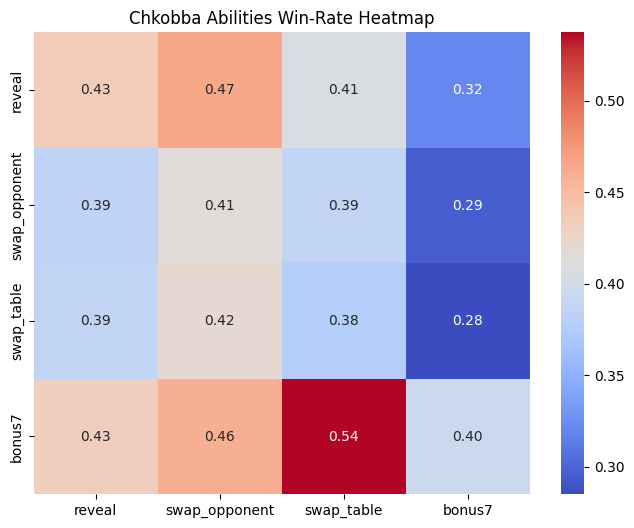


Top 5 matches summary:
              game_id player1_ability player2_ability   winner  p1_points  \
0  reveal_vs_reveal_0          reveal          reveal  Player2         18   
1  reveal_vs_reveal_1          reveal          reveal  Player2         16   
2  reveal_vs_reveal_2          reveal          reveal  Player2         18   
3  reveal_vs_reveal_3          reveal          reveal  Player1         22   
4  reveal_vs_reveal_4          reveal          reveal  Player2         18   

   p2_points  
0         22  
1         24  
2         22  
3         18  
4         22  


In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_deck():
    suits = ['♠', '♥', '♦', '♣']
    ranks = list(range(1, 8)) + ['J', 'Q', 'K']
    return [f"{r}{s}" for s in suits for r in ranks]

def card_value(card):
    r = card[:-1]
    if r == 'J': return 8
    if r == 'Q': return 9
    if r == 'K': return 10
    return int(r)

class Player:
    def __init__(self, name, ability=None):
        self.name = name
        self.ability = ability
        self.reset()

    def reset(self):
        self.hand = []
        self.captured = []
        self.points = 0
        self.ability_used = False

    def apply_ability(self, opponent, table, log, turn):
        if not self.ability or self.ability_used:
            return
        if self.ability == 'reveal':
            log.append({'turn': turn, 'player': self.name, 'action': 'reveal'})
        elif self.ability == 'swap_opponent':
            if self.hand and opponent.hand:
                my_card = random.choice(self.hand)
                opp_card = random.choice(opponent.hand)
                self.hand.remove(my_card)
                opponent.hand.remove(opp_card)
                self.hand.append(opp_card)
                opponent.hand.append(my_card)
                log.append({'turn': turn, 'player': self.name, 'action': 'swap_opponent'})
        elif self.ability == 'swap_table':
            if self.hand and table:
                my_card = random.choice(self.hand)
                table_card = random.choice(table)
                self.hand.remove(my_card)
                table.remove(table_card)
                self.hand.append(table_card)
                table.append(my_card)
                log.append({'turn': turn, 'player': self.name, 'action': 'swap_table'})
        self.ability_used = True

    def play_turn(self, table, log, turn):
        for card in self.hand:
            cv = card_value(card)
            for t in table:
                if card_value(t) == cv:
                    self.hand.remove(card)
                    table.remove(t)
                    self.captured.extend([card, t])
                    log.append({'turn': turn, 'player': self.name, 'action': f'capture {card}'})
                    return
        card = self.hand.pop(0)
        table.append(card)
        log.append({'turn': turn, 'player': self.name, 'action': f'place {card}'})

    def total_points(self):
        points = len(self.captured)
        if self.ability == 'bonus7' and '7♦' in self.captured:
            points += 1
        return points

def play_game(p1, p2):
    deck = create_deck()
    random.shuffle(deck)
    table = deck[:4]
    idx = 4
    log = []
    turn = 0

    p1.reset()
    p2.reset()

    while idx < len(deck) or p1.hand or p2.hand:
        if not p1.hand:
            p1.hand = deck[idx:idx+3]
            idx += 3
        if not p2.hand:
            p2.hand = deck[idx:idx+3]
            idx += 3

        turn += 1
        p1.apply_ability(p2, table, log, turn)
        p1.play_turn(table, log, turn)

        turn += 1
        p2.apply_ability(p1, table, log, turn)
        p2.play_turn(table, log, turn)

    p1.points = p1.total_points()
    p2.points = p2.total_points()

    if p1.points > p2.points:
        winner = "Player1"
    elif p2.points > p1.points:
        winner = "Player2"
    else:
        winner = "draw"

    return winner, p1.points, p2.points, log

def tournament(n_games=200):
    abilities = ['reveal', 'swap_opponent', 'swap_table', 'bonus7']
    results = np.zeros((len(abilities), len(abilities)))
    all_logs = []
    all_winners = []

    for i, ability1 in enumerate(abilities):
        for j, ability2 in enumerate(abilities):
            wins = 0
            for game_id in range(n_games):
                p1 = Player("Player1", ability1)
                p2 = Player("Player2", ability2)
                winner, p1_pts, p2_pts, log = play_game(p1, p2)
                if winner == "Player1":
                    wins += 1
                elif winner == "draw":
                    wins += 0.5

                all_winners.append({
                    'game_id': f"{ability1}_vs_{ability2}_{game_id}",
                    'player1_ability': ability1,
                    'player2_ability': ability2,
                    'winner': winner,
                    'p1_points': p1_pts,
                    'p2_points': p2_pts
                })

                for entry in log:
                    entry.update({
                        'game_id': f"{ability1}_vs_{ability2}_{game_id}",
                        'p1_ability': ability1,
                        'p2_ability': ability2
                    })
                all_logs.extend(log)

            results[i][j] = wins / n_games

    pd.DataFrame(all_logs).to_csv("match_logs.csv", index=False)
    pd.DataFrame(all_winners).to_csv("winners.csv", index=False)

    df_matrix = pd.DataFrame(results, index=abilities, columns=abilities)
    return df_matrix, pd.DataFrame(all_winners)

if __name__ == "__main__":
    print("\n🔷 Running Chkobba Tournament with detailed winners …")
    matrix, winners_df = tournament(200)

    print("\nWin-rate matrix:\n")
    print(matrix.round(2))

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Chkobba Abilities Win-Rate Heatmap")
    plt.show()

    print("\nTop 5 matches summary:")
    print(winners_df.head())


🔷 Running Chkobba Tournament with full analytics …

Win-rate matrix:

               reveal  swap_opponent  swap_table  bonus7
reveal           0.46           0.42        0.46    0.34
swap_opponent    0.34           0.44        0.44    0.33
swap_table       0.35           0.44        0.46    0.30
bonus7           0.49           0.48        0.46    0.36


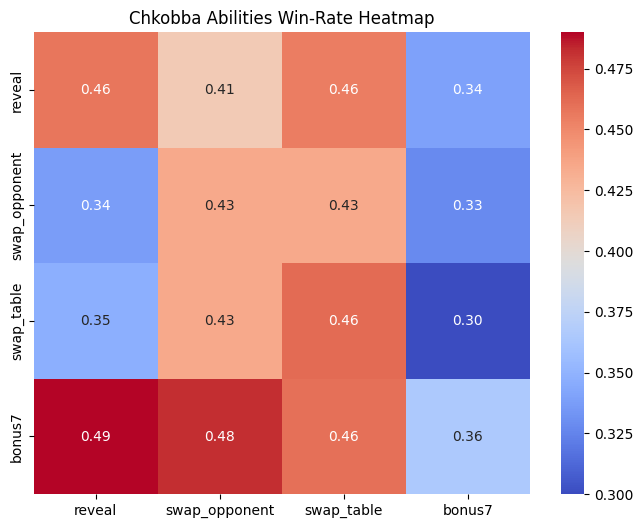

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def create_deck():
    suits = ['♠', '♥', '♦', '♣']
    ranks = list(range(1, 8)) + ['J', 'Q', 'K']
    return [f"{r}{s}" for s in suits for r in ranks]


def card_value(card):
    r = card[:-1]
    if r == 'J': return 8
    if r == 'Q': return 9
    if r == 'K': return 10
    return int(r)


class Player:
    def __init__(self, name, ability=None):
        self.name = name
        self.ability = ability
        self.reset()

    def reset(self):
        self.hand = []
        self.captured = []
        self.points = 0
        self.ability_used = False
        self.ability_was_triggered = False

    def apply_ability(self, opponent, table, log, turn):
        if not self.ability or self.ability_used:
            return

        log_entry = {
            'turn': turn,
            'player': self.name,
            'action': self.ability,
            'hand_size_at_use': len(self.hand),
            'table': table.copy(),
            'winner': None,
            'game_id': None,
            'p1_ability': None,
            'p2_ability': None
        }

        if self.ability == 'reveal':
            log_entry['opponent_hand'] = opponent.hand.copy()
        elif self.ability == 'swap_opponent':
            if self.hand and opponent.hand:
                my_card = random.choice(self.hand)
                opp_card = random.choice(opponent.hand)
                self.hand.remove(my_card)
                opponent.hand.remove(opp_card)
                self.hand.append(opp_card)
                opponent.hand.append(my_card)
                log_entry['swapped_my_card'] = my_card
                log_entry['swapped_opp_card'] = opp_card
        elif self.ability == 'swap_table':
            if self.hand and table:
                my_card = random.choice(self.hand)
                table_card = random.choice(table)
                self.hand.remove(my_card)
                table.remove(table_card)
                self.hand.append(table_card)
                table.append(my_card)
                log_entry['swapped_my_card'] = my_card
                log_entry['swapped_table_card'] = table_card

        log.append(log_entry)
        self.ability_used = True
        self.ability_was_triggered = True

    def play_turn(self, table, log, turn):
        for card in self.hand:
            cv = card_value(card)
            for t in table:
                if card_value(t) == cv:
                    self.hand.remove(card)
                    table.remove(t)
                    self.captured.extend([card, t])
                    log.append({
                        'turn': turn,
                        'player': self.name,
                        'action': f'capture {card}'
                    })
                    return
        card = self.hand.pop(0)
        table.append(card)
        log.append({
            'turn': turn,
            'player': self.name,
            'action': f'place {card}'
        })

    def total_points(self):
        points = len(self.captured)
        if self.ability == 'bonus7' and '7♦' in self.captured:
            points += 1
        return points


def play_game(p1, p2):
    deck = create_deck()
    random.shuffle(deck)
    table = deck[:4]
    idx = 4
    log = []
    turn = 0

    p1.reset()
    p2.reset()

    while idx < len(deck) or p1.hand or p2.hand:
        if not p1.hand:
            p1.hand = deck[idx:idx+3]
            idx += 3
        if not p2.hand:
            p2.hand = deck[idx:idx+3]
            idx += 3

        turn += 1
        p1.apply_ability(p2, table, log, turn)
        p1.play_turn(table, log, turn)

        turn += 1
        p2.apply_ability(p1, table, log, turn)
        p2.play_turn(table, log, turn)

    p1.points = p1.total_points()
    p2.points = p2.total_points()

    if p1.points > p2.points:
        winner = "Player1"
    elif p2.points > p1.points:
        winner = "Player2"
    else:
        winner = "draw"

    return winner, p1.points, p2.points, log, p1.ability_was_triggered, p2.ability_was_triggered


def tournament(n_games=200):
    abilities = ['reveal', 'swap_opponent', 'swap_table', 'bonus7']
    results = np.zeros((len(abilities), len(abilities)))
    all_logs = []
    all_winners = []
    all_ability_usage = []

    for i, ability1 in enumerate(abilities):
        for j, ability2 in enumerate(abilities):
            wins = 0
            for game_id in range(n_games):
                p1 = Player("Player1", ability1)
                p2 = Player("Player2", ability2)
                winner, p1_pts, p2_pts, log, p1_used, p2_used = play_game(p1, p2)
                if winner == "Player1":
                    wins += 1
                elif winner == "draw":
                    wins += 0.5

                game_name = f"{ability1}_vs_{ability2}_{game_id}"

                all_winners.append({
                    'game_id': game_name,
                    'player1_ability': ability1,
                    'player2_ability': ability2,
                    'winner': winner,
                    'p1_points': p1_pts,
                    'p2_points': p2_pts
                })

                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player1",
                    'ability': ability1,
                    'used': p1_used
                })
                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player2",
                    'ability': ability2,
                    'used': p2_used
                })

                for entry in log:
                    entry.update({
                        'game_id': game_name,
                        'winner': winner,
                        'p1_ability': ability1,
                        'p2_ability': ability2
                    })
                all_logs.extend(log)

            results[i][j] = wins / n_games

    df_logs = pd.DataFrame(all_logs)
    df_winners = pd.DataFrame(all_winners)
    df_ability_usage = pd.DataFrame(all_ability_usage)

    df_logs.to_csv("match_logs.csv", index=False)
    df_winners.to_csv("winners.csv", index=False)
    df_ability_usage.to_csv("ability_usage.csv", index=False)

    # 🔷 Génération des 3 fichiers ability_usage_<ability>.csv
    abilities_to_log = ['reveal', 'swap_opponent', 'swap_table']
    for ability in abilities_to_log:
        usage_rows = []
        for _, row in df_logs.iterrows():
            if row['action'] != ability:
                continue
            player = row['player']
            winner = row['winner']
            adv = (winner == player) or (winner == 'draw')
            hand_size = row.get('hand_size_at_use', 3)
            optimal = (hand_size == 3)
            usage_rows.append({
                'game_id': row['game_id'],
                'player': player,
                'table': row.get('table', []),
                'hand_size_at_use': hand_size,
                'optimal_timing': optimal,
                'advantageous': adv
            })
        df_ability = pd.DataFrame(usage_rows)
        df_ability.to_csv(f"ability_usage_{ability}.csv", index=False)

    df_matrix = pd.DataFrame(results, index=abilities, columns=abilities)
    return df_matrix


if __name__ == "__main__":
    print("\n🔷 Running Chkobba Tournament with full analytics …")
    matrix = tournament(200)

    print("\nWin-rate matrix:\n")
    print(matrix.round(2))

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Chkobba Abilities Win-Rate Heatmap")
    plt.show()



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)

    # table et hand sont des listes de str sous forme texte → eval pour les décoder
    df['table'] = df['table'].apply(eval)
    df['hand'] = df['hand'].apply(eval)

    mlb_table = MultiLabelBinarizer()
    mlb_hand = MultiLabelBinarizer()

    X_table = mlb_table.fit_transform(df['table'])
    X_hand = mlb_hand.fit_transform(df['hand'])

    X = pd.concat([pd.DataFrame(X_table), pd.DataFrame(X_hand)], axis=1)
    y = df['advantageous'].astype(int)

    return X, y, mlb_table, mlb_hand


def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    return clf


if __name__ == "__main__":
    files = [
        "ability_usage_swap_opponent.csv",
        "ability_usage_swap_table.csv",
    ]

    for file in files:
        print(f"\n🔷 Training model for {file}")
        X, y, mlb_table, mlb_hand = load_and_preprocess(file)
        model = train_and_evaluate(X, y)


🔷 Training model for ability_usage_swap_opponent.csv
              precision    recall  f1-score   support

           0       0.28      0.29      0.28       119
           1       0.57      0.57      0.57       201

    accuracy                           0.47       320
   macro avg       0.43      0.43      0.43       320
weighted avg       0.47      0.47      0.47       320


🔷 Training model for ability_usage_swap_table.csv
              precision    recall  f1-score   support

           0       0.45      0.24      0.31       142
           1       0.56      0.76      0.64       178

    accuracy                           0.53       320
   macro avg       0.50      0.50      0.48       320
weighted avg       0.51      0.53      0.50       320




🔷 Running Chkobba Tournament with full analytics …

Win-rate matrix:

               reveal  swap_opponent  swap_table  bonus7
reveal           0.35           0.41        0.47    0.37
swap_opponent    0.42           0.40        0.45    0.40
swap_table       0.43           0.46        0.41    0.36
bonus7           0.45           0.54        0.48    0.39


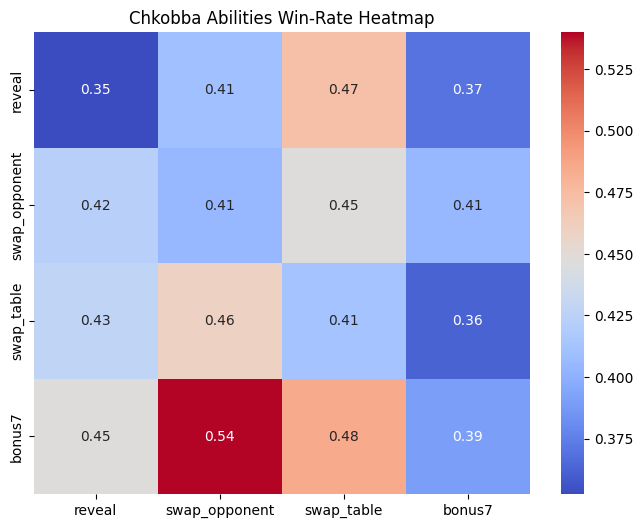

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def create_deck():
    suits = ['♠', '♥', '♦', '♣']
    ranks = list(range(1, 8)) + ['J', 'Q', 'K']
    return [f"{r}{s}" for s in suits for r in ranks]


def card_value(card):
    r = card[:-1]
    if r == 'J': return 8
    if r == 'Q': return 9
    if r == 'K': return 10
    return int(r)


class Player:
    def __init__(self, name, ability=None):
        self.name = name
        self.ability = ability
        self.reset()

    def reset(self):
        self.hand = []
        self.captured = []
        self.points = 0
        self.ability_used = False
        self.ability_was_triggered = False

    def apply_ability(self, opponent, table, log, turn):
        if not self.ability or self.ability_used:
            return

        if self.ability == 'reveal':
            log.append({
                'turn': turn,
                'player': self.name,
                'action': 'reveal',
                'opponent_hand': opponent.hand.copy(),
                'table': table.copy(),
                'winner': None,  # ajouté plus tard
                'game_id': None,
                'p1_ability': None,
                'p2_ability': None
            })
        elif self.ability == 'swap_opponent':
            if self.hand and opponent.hand:
                my_card = random.choice(self.hand)
                opp_card = random.choice(opponent.hand)
                self.hand.remove(my_card)
                opponent.hand.remove(opp_card)
                self.hand.append(opp_card)
                opponent.hand.append(my_card)
                log.append({
                    'turn': turn,
                    'player': self.name,
                    'action': 'swap_opponent',
                    'swapped_my_card': my_card,
                    'swapped_opp_card': opp_card,
                    'table': table.copy(),
                    'winner': None,
                    'game_id': None,
                    'p1_ability': None,
                    'p2_ability': None
                })
        elif self.ability == 'swap_table':
            if self.hand and table:
                my_card = random.choice(self.hand)
                table_card = random.choice(table)
                self.hand.remove(my_card)
                table.remove(table_card)
                self.hand.append(table_card)
                table.append(my_card)
                log.append({
                    'turn': turn,
                    'player': self.name,
                    'action': 'swap_table',
                    'swapped_my_card': my_card,
                    'swapped_table_card': table_card,
                    'table': table.copy(),
                    'winner': None,
                    'game_id': None,
                    'p1_ability': None,
                    'p2_ability': None
                })
        self.ability_used = True
        self.ability_was_triggered = True

    def play_turn(self, table, log, turn):
        for card in self.hand:
            cv = card_value(card)
            for t in table:
                if card_value(t) == cv:
                    self.hand.remove(card)
                    table.remove(t)
                    self.captured.extend([card, t])
                    log.append({
                        'turn': turn,
                        'player': self.name,
                        'action': f'capture {card}'
                    })
                    return
        card = self.hand.pop(0)
        table.append(card)
        log.append({
            'turn': turn,
            'player': self.name,
            'action': f'place {card}'
        })

    def total_points(self):
        points = len(self.captured)
        if self.ability == 'bonus7' and '7♦' in self.captured:
            points += 1
        return points


def play_game(p1, p2):
    deck = create_deck()
    random.shuffle(deck)
    table = deck[:4]
    idx = 4
    log = []
    turn = 0

    p1.reset()
    p2.reset()

    while idx < len(deck) or p1.hand or p2.hand:
        if not p1.hand:
            p1.hand = deck[idx:idx+3]
            idx += 3
        if not p2.hand:
            p2.hand = deck[idx:idx+3]
            idx += 3

        turn += 1
        p1.apply_ability(p2, table, log, turn)
        p1.play_turn(table, log, turn)

        turn += 1
        p2.apply_ability(p1, table, log, turn)
        p2.play_turn(table, log, turn)

    p1.points = p1.total_points()
    p2.points = p2.total_points()

    if p1.points > p2.points:
        winner = "Player1"
    elif p2.points > p1.points:
        winner = "Player2"
    else:
        winner = "draw"

    return winner, p1.points, p2.points, log, p1.ability_was_triggered, p2.ability_was_triggered


def tournament(n_games=200):
    abilities = ['reveal', 'swap_opponent', 'swap_table', 'bonus7']
    results = np.zeros((len(abilities), len(abilities)))
    all_logs = []
    all_winners = []
    all_ability_usage = []

    for i, ability1 in enumerate(abilities):
        for j, ability2 in enumerate(abilities):
            wins = 0
            for game_id in range(n_games):
                p1 = Player("Player1", ability1)
                p2 = Player("Player2", ability2)
                winner, p1_pts, p2_pts, log, p1_used, p2_used = play_game(p1, p2)
                if winner == "Player1":
                    wins += 1
                elif winner == "draw":
                    wins += 0.5

                game_name = f"{ability1}_vs_{ability2}_{game_id}"

                all_winners.append({
                    'game_id': game_name,
                    'player1_ability': ability1,
                    'player2_ability': ability2,
                    'winner': winner,
                    'p1_points': p1_pts,
                    'p2_points': p2_pts
                })

                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player1",
                    'ability': ability1,
                    'used': p1_used
                })
                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player2",
                    'ability': ability2,
                    'used': p2_used
                })

                for entry in log:
                    entry.update({
                        'game_id': game_name,
                        'winner': winner,
                        'p1_ability': ability1,
                        'p2_ability': ability2
                    })
                all_logs.extend(log)

            results[i][j] = wins / n_games

    # 🔷 Sauvegardes principales
    df_logs = pd.DataFrame(all_logs)
    df_winners = pd.DataFrame(all_winners)
    df_ability_usage = pd.DataFrame(all_ability_usage)

    df_logs.to_csv("match_logs.csv", index=False)
    df_winners.to_csv("winners.csv", index=False)
    df_ability_usage.to_csv("ability_usage.csv", index=False)

    # 🔷 Génération des 4 fichiers ability_usage_<ability>.csv
    abilities = ['reveal', 'swap_opponent', 'swap_table', 'bonus7']
    for ability in abilities:
        usage_rows = []
        for _, row in df_logs.iterrows():
            if row['action'] != ability:
                continue
            player = row['player']
            winner = row['winner']
            adv = (winner == player) or (winner == 'draw')
            usage_rows.append({
                'game_id': row['game_id'],
                'player': player,
                'table': row.get('table', []),
                'hand': row.get('opponent_hand', []) if ability == 'reveal' else [],
                'advantageous': adv
            })
        df_ability = pd.DataFrame(usage_rows)
        df_ability.to_csv(f"ability_usage_{ability}.csv", index=False)

    df_matrix = pd.DataFrame(results, index=abilities, columns=abilities)
    return df_matrix


if __name__ == "__main__":
    print("\n🔷 Running Chkobba Tournament with full analytics …")
    matrix = tournament(200)

    print("\nWin-rate matrix:\n")
    print(matrix.round(2))

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Chkobba Abilities Win-Rate Heatmap")
    plt.show()



🔷 Running Chkobba Tournament with full analytics …

Win-rate matrix:

               reveal  swap_opponent  swap_table  bonus7
reveal           0.42           0.44        0.42    0.34
swap_opponent    0.42           0.40        0.40    0.34
swap_table       0.36           0.39        0.38    0.36
bonus7           0.41           0.55        0.43    0.40


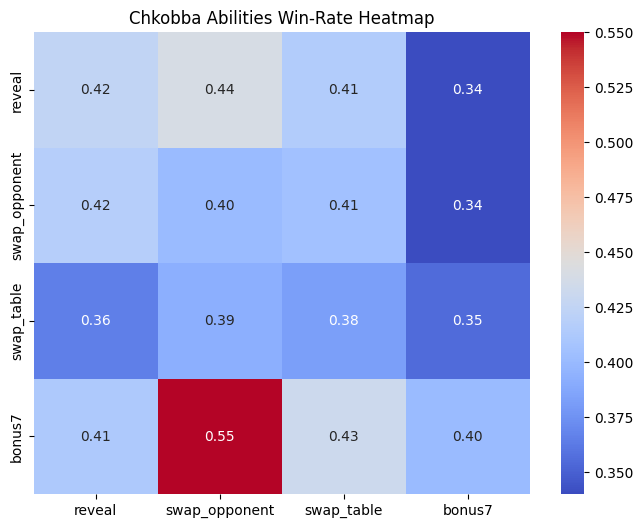

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def create_deck():
    suits = ['♠', '♥', '♦', '♣']
    ranks = list(range(1, 8)) + ['J', 'Q', 'K']
    return [f"{r}{s}" for s in suits for r in ranks]


def card_value(card):
    r = card[:-1]
    if r == 'J': return 8
    if r == 'Q': return 9
    if r == 'K': return 10
    return int(r)


class Player:
    def __init__(self, name, ability=None):
        self.name = name
        self.ability = ability
        self.reset()

    def reset(self):
        self.hand = []
        self.captured = []
        self.points = 0
        self.ability_used = False
        self.ability_was_triggered = False

    def apply_ability(self, opponent, table, log, turn):
        if not self.ability or self.ability_used:
            return

        log_entry = {
            'turn': turn,
            'player': self.name,
            'action': self.ability,
            'hand_size_at_use': len(self.hand),
            'table': table.copy(),
            'winner': None,
            'game_id': None,
            'p1_ability': None,
            'p2_ability': None
        }

        if self.ability == 'reveal':
            log_entry['opponent_hand'] = opponent.hand.copy()
        elif self.ability == 'swap_opponent':
            if self.hand and opponent.hand:
                my_card = random.choice(self.hand)
                opp_card = random.choice(opponent.hand)
                self.hand.remove(my_card)
                opponent.hand.remove(opp_card)
                self.hand.append(opp_card)
                opponent.hand.append(my_card)
                log_entry['swapped_my_card'] = my_card
                log_entry['swapped_opp_card'] = opp_card
        elif self.ability == 'swap_table':
            if self.hand and table:
                my_card = random.choice(self.hand)
                table_card = random.choice(table)
                self.hand.remove(my_card)
                table.remove(table_card)
                self.hand.append(table_card)
                table.append(my_card)
                log_entry['swapped_my_card'] = my_card
                log_entry['swapped_table_card'] = table_card

        log.append(log_entry)
        self.ability_used = True
        self.ability_was_triggered = True

    def play_turn(self, table, log, turn):
        for card in self.hand:
            cv = card_value(card)
            for t in table:
                if card_value(t) == cv:
                    self.hand.remove(card)
                    table.remove(t)
                    self.captured.extend([card, t])
                    log.append({
                        'turn': turn,
                        'player': self.name,
                        'action': f'capture {card}'
                    })
                    return
        card = self.hand.pop(0)
        table.append(card)
        log.append({
            'turn': turn,
            'player': self.name,
            'action': f'place {card}'
        })

    def total_points(self):
        points = len(self.captured)
        if self.ability == 'bonus7' and '7♦' in self.captured:
            points += 1
        return points


def play_game(p1, p2):
    deck = create_deck()
    random.shuffle(deck)
    table = deck[:4]
    idx = 4
    log = []
    turn = 0

    p1.reset()
    p2.reset()

    while idx < len(deck) or p1.hand or p2.hand:
        if not p1.hand:
            p1.hand = deck[idx:idx+3]
            idx += 3
        if not p2.hand:
            p2.hand = deck[idx:idx+3]
            idx += 3

        turn += 1
        p1.apply_ability(p2, table, log, turn)
        p1.play_turn(table, log, turn)

        turn += 1
        p2.apply_ability(p1, table, log, turn)
        p2.play_turn(table, log, turn)

    p1.points = p1.total_points()
    p2.points = p2.total_points()

    if p1.points > p2.points:
        winner = "Player1"
    elif p2.points > p1.points:
        winner = "Player2"
    else:
        winner = "draw"

    return winner, p1.points, p2.points, log, p1.ability_was_triggered, p2.ability_was_triggered


def tournament(n_games=200):
    abilities = ['reveal', 'swap_opponent', 'swap_table', 'bonus7']
    results = np.zeros((len(abilities), len(abilities)))
    all_logs = []
    all_winners = []
    all_ability_usage = []

    for i, ability1 in enumerate(abilities):
        for j, ability2 in enumerate(abilities):
            wins = 0
            for game_id in range(n_games):
                p1 = Player("Player1", ability1)
                p2 = Player("Player2", ability2)
                winner, p1_pts, p2_pts, log, p1_used, p2_used = play_game(p1, p2)
                if winner == "Player1":
                    wins += 1
                elif winner == "draw":
                    wins += 0.5

                game_name = f"{ability1}_vs_{ability2}_{game_id}"

                all_winners.append({
                    'game_id': game_name,
                    'player1_ability': ability1,
                    'player2_ability': ability2,
                    'winner': winner,
                    'p1_points': p1_pts,
                    'p2_points': p2_pts
                })

                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player1",
                    'ability': ability1,
                    'used': p1_used
                })
                all_ability_usage.append({
                    'game_id': game_name,
                    'player': "Player2",
                    'ability': ability2,
                    'used': p2_used
                })

                for entry in log:
                    entry.update({
                        'game_id': game_name,
                        'winner': winner,
                        'p1_ability': ability1,
                        'p2_ability': ability2
                    })
                all_logs.extend(log)

            results[i][j] = wins / n_games

    df_logs = pd.DataFrame(all_logs)
    df_winners = pd.DataFrame(all_winners)
    df_ability_usage = pd.DataFrame(all_ability_usage)

    df_logs.to_csv("match_logs.csv", index=False)
    df_winners.to_csv("winners.csv", index=False)
    df_ability_usage.to_csv("ability_usage.csv", index=False)

    # 🔷 Génération des 3 fichiers ability_usage_<ability>.csv
    abilities_to_log = ['reveal', 'swap_opponent', 'swap_table']
    for ability in abilities_to_log:
        usage_rows = []
        for _, row in df_logs.iterrows():
            if row['action'] != ability:
                continue
            player = row['player']
            winner = row['winner']
            adv = (winner == player) or (winner == 'draw')
            hand_size = row.get('hand_size_at_use', 3)
            optimal = (hand_size == 3)
            usage_rows.append({
                'game_id': row['game_id'],
                'player': player,
                'table': row.get('table', []),
                'hand_size_at_use': hand_size,
                'optimal_timing': optimal,
                'advantageous': adv
            })
        df_ability = pd.DataFrame(usage_rows)
        df_ability.to_csv(f"ability_usage_{ability}.csv", index=False)

    df_matrix = pd.DataFrame(results, index=abilities, columns=abilities)
    return df_matrix


if __name__ == "__main__":
    print("\n🔷 Running Chkobba Tournament with full analytics …")
    matrix = tournament(200)

    print("\nWin-rate matrix:\n")
    print(matrix.round(2))

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Chkobba Abilities Win-Rate Heatmap")
    plt.show()
